In [1]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import time

#读取数据
features = pd.read_csv("E:\\machineLearning\\kaggle\\dataset\\temps_extended.csv")
features.head(5)

,year,month,day,weekday,ws_1,prcp_1,snwd_1,temp_2,temp_1,average,actual,friend
0,2011,1,1,Sat,4.92,0.00,0,36,37,45.6,40,40
1,2011,1,2,Sun,5.37,0.00,0,37,40,45.7,39,50
2,2011,1,3,Mon,6.26,0.00,0,40,39,45.8,42,42
3,2011,1,4,Tues,5.59,0.00,0,39,42,45.9,38,59
4,2011,1,5,Wed,3.80,0.03,0,42,38,46.0,45,39


数据规模： (2191, 12)


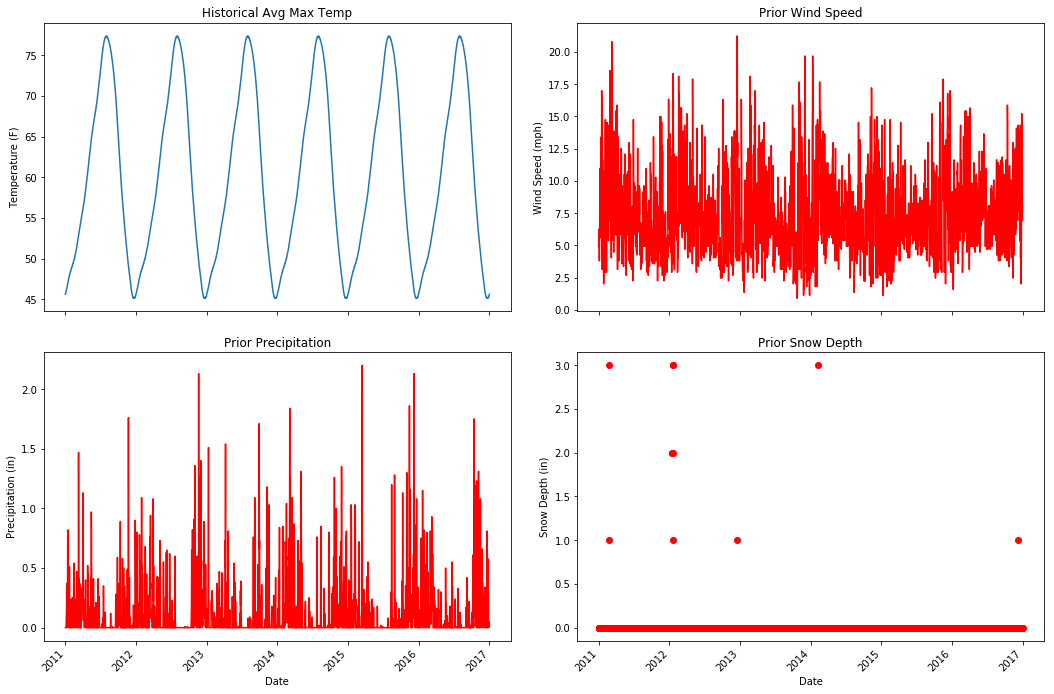

In [2]:
#可视化与预处理
print('数据规模：', features.shape)
years = features['year']
months = features['month']
days = features['day']
dates = [str(int(year)) + '-' + str(int(month)) + '-' + str(int(day))
         for year,month,day in zip(years, months, days)]
dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in dates]
#绘图
warnings.filterwarnings("ignore")
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize = (15,10))
fig.autofmt_xdate(rotation=45)
ax1.plot(dates, features['average']) #平均最高气温
ax1.set_xlabel(''); ax1.set_ylabel('Temperature (F)'); ax1.set_title('Historical Avg Max Temp')
ax2.plot(dates, features['ws_1'], 'r-') #风速
ax2.set_xlabel(''); ax2.set_ylabel('Wind Speed (mph)'); ax2.set_title('Prior Wind Speed')
ax3.plot(dates, features['prcp_1'], 'r-') #降水
ax3.set_xlabel('Date'); ax3.set_ylabel('Precipitation (in)'); ax3.set_title('Prior Precipitation')
ax4.plot(dates, features['snwd_1'], 'ro') #积雪
ax4.set_xlabel('Date'); ax4.set_ylabel('Snow Depth (in)'); ax4.set_title('Prior Snow Depth')
plt.tight_layout(pad=2)

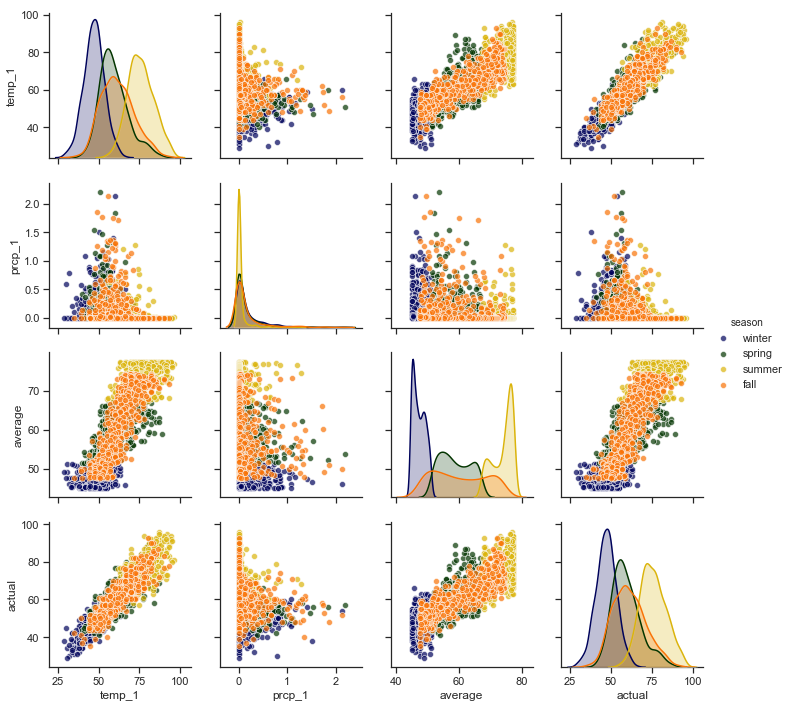

In [3]:
#特征工程
#创建季节变量
seasons = []
for month in features['month']:
    if month in [1, 2, 12]:
        seasons.append('winter')
    elif month in [3, 4, 5]:
        seasons.append('spring')
    elif month in [6, 7, 8]:
        seasons.append('summer')
    elif month in [9, 10, 11]:
        seasons.append('fall')
reduced_features = features[['temp_1', 'prcp_1', 'average', 'actual']]
reduced_features['season'] = seasons
#不同季节各项特征变化
sns.set(style="ticks", color_codes=True);
palette = sns.xkcd_palette(['dark blue', 'dark green', 'gold', 'orange'])
sns.pairplot(reduced_features, hue= 'season', diag_kind= 'kde', palette=palette,
            plot_kws=dict(alpha=0.7), diag_kws=dict(shade=True))

In [4]:
#1. 数据量对结果影响分析
#新数据集预处理
features = pd.get_dummies(features) #独热编码
labels = features['actual']
features = features.drop('actual', axis=1) #提取特征和标签
feature_list = list(features.columns)
features = np.array(features)
labels = np.array(labels) #标签转换
train_features, test_features, train_labels, test_labels = (
    train_test_split(features, labels, test_size=0.25, random_state=0)) #切分数据集
print('训练集特征：', train_features.shape)
print('训练集标签：', train_labels.shape)
print('测试集特征：', test_features.shape)
print('测试集标签：', test_labels.shape)

训练集特征： (1643, 17)
训练集标签： (1643,)
测试集特征： (548, 17)
测试集标签： (548,)


In [5]:
#老数据集预处理
original_feature_indices = [feature_list.index(feature) for feature in feature_list
                            if feature not in ['ws_1', 'prcp_1', 'snwd_1']]
original_features = pd.read_csv("E:\\machineLearning\\kaggle\\dataset\\temps.csv")
original_features = pd.get_dummies(original_features) #独热编码
original_labels = np.array(original_features['actual'])
original_features = original_features.drop('actual', axis=1) #提取特征和标签
original_feature_list = list(original_features.columns)
original_features = np.array(original_features) #标签转换
original_train_features, original_test_features, original_train_labels, original_test_labels = (
    train_test_split(original_features, original_labels, test_size=0.25, random_state=42)) #切分数据集

In [6]:
#建模
#较少数据集
rf = RandomForestRegressor(n_estimators=100, random_state=0)
rf.fit(original_train_features, original_train_labels); #老数据集训练
predictions = rf.predict(test_features[:, original_feature_indices]) #新数据集的测试集
errors = abs(predictions - test_labels)
print('样本较少时平均温度误差：', round(np.mean(errors), 2), 'degrees.') #平均温度误差
mape = 100 * (errors / test_labels)
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%')

样本较少时平均温度误差： 4.67 degrees.
Accuracy: 92.2 %


In [7]:
#较多数据集
original_train_features = train_features[:, original_feature_indices]
original_test_features = test_features[:, original_feature_indices]
rf = RandomForestRegressor(n_estimators=100, random_state=0)
rf.fit(original_train_features, train_labels); #新数据集训练
baseline_predictions = rf.predict(original_test_features) #新数据集测试
baseline_errors = abs(baseline_predictions - test_labels)
print('样本较多时平均温度误差：', round(np.mean(baseline_errors), 2), 'degrees.') #平均温度误差
baseline_mape = 100 * (baseline_errors / test_labels)
baseline_accuracy = 100 - np.mean(baseline_mape)
print('Accuracy:', round(baseline_accuracy, 2), '%')

样本较多时平均温度误差： 4.2 degrees.
Accuracy: 93.12 %


In [8]:
#2. 特征数量对结果影响分析
rf_exp = RandomForestRegressor(n_estimators=100, random_state=0)
rf_exp.fit(train_features, train_labels)
predictions = rf_exp.predict(test_features)
errors = abs(predictions - test_labels)
print('加入特征后的平均温度误差：', round(np.mean(errors), 2), 'degrees.') #平均温度误差
mape = np.mean(100 * (errors / test_labels))
improvement_baseline = np.mean(100 * abs(mape - baseline_mape) / baseline_mape) #存疑？
print('加入特征后模型效果提升：', round(improvement_baseline, 2), '%.') #存疑？
accuracy = 100 - mape
print('Accuracy:', round(accuracy, 2), '%')

加入特征后的平均温度误差： 4.05 degrees.
加入特征后模型效果提升： inf %.
Accuracy: 93.35 %


Variable:temp_1               Importance:0.85
Variable:average              Importance:0.05
Variable:ws_1                 Importance:0.02
Variable:friend               Importance:0.02
Variable:year                 Importance:0.01
Variable:month                Importance:0.01
Variable:day                  Importance:0.01
Variable:prcp_1               Importance:0.01
Variable:temp_2               Importance:0.01
Variable:snwd_1               Importance:0.0
Variable:weekday_Fri          Importance:0.0
Variable:weekday_Mon          Importance:0.0
Variable:weekday_Sat          Importance:0.0
Variable:weekday_Sun          Importance:0.0
Variable:weekday_Thurs        Importance:0.0
Variable:weekday_Tues         Importance:0.0
Variable:weekday_Wed          Importance:0.0


Text(0.5,1,'Variable Importances')

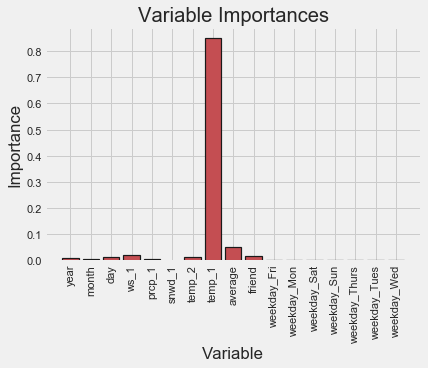

In [9]:
#特征重要性
importances = list(rf_exp.feature_importances_)
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
feature_importances = sorted(feature_importances, key=lambda x : x[1], reverse=True) #排序
[print('Variable:{:20} Importance:{}'.format(*pair)) for pair in feature_importances]
#绘制成图表
plt.style.use('fivethirtyeight')
x_values = list(range(len(importances)))
plt.bar(x_values, importances, orientation='vertical', color='r', edgecolor='k', linewidth=1.2)
plt.xticks(x_values, feature_list, rotation='vertical')
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances')

Text(0.5,1,'Cumulative Importance')

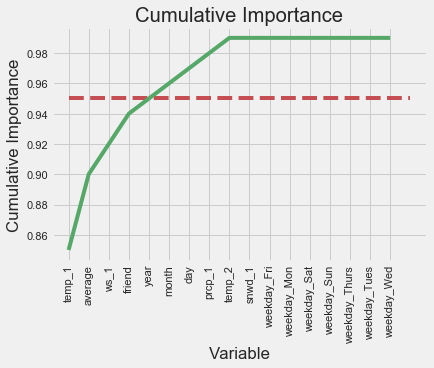

In [10]:
#筛选特征
sorted_importances = [importance[1] for importance in feature_importances]
sorted_features = [importance[0] for importance in feature_importances]
cumulative_importances = np.cumsum(sorted_importances) #累计重要性
plt.plot(x_values, cumulative_importances, 'g-')
plt.hlines(y=0.95, xmin=0, xmax=len(sorted_importances), colors='r', linestyles='dashed')
plt.xticks(x_values, sorted_features, rotation='vertical')
plt.xlabel('Variable');plt.ylabel('Cumulative Importance')
plt.title('Cumulative Importance')

In [11]:
#2.1 只用前5个特征建模，发现效果没有提升
important_feature_name = [feature[0] for feature in feature_importances[0:5]]
important_indices = [feature_list.index(feature) for feature in important_feature_name]
important_train_features = train_features[:, important_indices]
important_test_features = test_features[:, important_indices]
print('重要参数训练集大小：', important_train_features.shape)
print('重要参数测试集大小：', important_test_features.shape)
rf_exp.fit(important_train_features, train_labels)
predictions = rf_exp.predict(important_test_features)
errors = abs(predictions - test_labels)
print('选择重要参数建模后的平均温度误差：', round(np.mean(errors), 2), 'degrees.') #平均温度误差
mape = 100 * (errors / test_labels)
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%')

重要参数训练集大小： (1643, 5)
重要参数测试集大小： (548, 5)
选择重要参数建模后的平均温度误差： 4.11 degrees.
Accuracy: 93.28 %


In [12]:
#2.2 比较时间效率
all_features_time = []
for _ in range(10):
    start_time = time.time()
    rf_exp.fit(train_features, train_labels)
    all_feature_predictions = rf_exp.predict(test_features)
    end_time = time.time()
    all_features_time.append(end_time - start_time)
all_feature_time = np.mean(all_features_time)
print('使用所有特征建模与测试时的平均时间消耗：', round(all_feature_time, 2), '秒')

使用所有特征建模与测试时的平均时间消耗： 0.4 秒


In [13]:
#使用部分重要特征
reduced_features_time = []
for _ in range(10):
    start_time = time.time()
    rf_exp.fit(important_train_features, train_labels)
    reduced_feature_predictions = rf_exp.predict(important_test_features)
    end_time = time.time()
    reduced_features_time.append(end_time - start_time)
reduced_feature_time = np.mean(reduced_features_time)
print('使用所有特征建模与测试时的平均时间消耗：', round(reduced_feature_time, 2), '秒')

使用所有特征建模与测试时的平均时间消耗： 0.24 秒


In [14]:
#展示对比情况
all_accuracy = 100 * (1 - np.mean(abs(all_feature_predictions - test_labels) / test_labels))
reduced_accuracy = 100 * (1 - np.mean(abs(reduced_feature_predictions - test_labels) / test_labels))
comparison = pd.DataFrame({'features': ['all(17)', 'reduced(5)'],
                           'run_time':[round(all_feature_time, 2), round(reduced_feature_time, 2)],
                           'accuracy':[round(all_accuracy, 2), round(reduced_accuracy, 2)]})
comparison[['features', 'accuracy', 'run_time']]

,features,accuracy,run_time
0,all(17),93.35,0.40
1,reduced(5),93.28,0.24


In [16]:
#模型调参 —— 内存不足！
#随机参数选择

from sklearn.model_selection import RandomizedSearchCV
n_estimators = [int(x) for x in np.linspace(start=200,stop=2000,num=10)] # 建立树的个数
max_features = ['auto','sqrt'] # 最大特征的选择方法
max_depth = [int(x) for x in np.linspace(10,20,num=2)] # 树最大深度
max_depth.append(None)
min_samples_split = [2,5,10] # 节点最小分裂所需要的样本个数
min_samples_leaf = [1,2,4] # 叶子节点最小的样本数
bootstrap = [True,False] # 样本采样方法
random_grid ={'n_estimators':n_estimators,
             'max_features':max_features,
             'max_depth':max_depth,
             'min_samples_split':min_samples_split,
             'min_samples_leaf':min_samples_leaf,
             'bootstrap':bootstrap} # 随机参数空间

rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator=rf, # 指定调参模型
                            param_distributions=random_grid, # 指定候选参数列表
                            n_iter=100, # 随机选择参数组合的个数，这里是随机选择100组，找这中间最好的
                            scoring='neg_mean_absolute_error', # 评估方法
                            cv=3, # 交叉验证
                            verbose=2, # 打印信息的数量
                            random_state=42, # 随机种子，随便选
                            n_jobs=-1) # 多线程数目，如果-1代表使用所有线程
# 寻找开始
rf_random.fit(train_features,train_labels)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker.


In [ ]:
_